In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

%matplotlib inline

spark = SparkSession.builder.getOrCreate()


In [12]:
food_facts = spark.read.csv('../data/raw/en.openfoodfacts.org.products.csv', header=True, sep="\t")
food_facts.registerTempTable('food_facts')

In [13]:
food_facts.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [47]:
number_of_products = food_facts.count()
print(number_of_products)

685395


In [23]:
print("Number of distinct city tags without france: {}".format(
    food_facts.select('cities_tags').filter('cities_tags NOT LIKE "%france%"')
    .distinct().count())
)
print("Number of distinct city tags : {}".format(
    food_facts.select('cities_tags').distinct().count())
)

Number of city tags without france: 3
Number of city tags : 3317


In [25]:
print("Number of distinct purchase places without france in the name: {}".format(
    food_facts.select('purchase_places').filter('LOWER(purchase_places) NOT LIKE "%france%"')
    .distinct().count()))
print("Number of distinct purchase places : {}".format(
    food_facts.select('purchase_places').distinct().count()))

Number of purchase places without france in the name: 3403
Number of purchase places : 7720


In [26]:
print("Number of manufacturing places without france in the name: {}".format(
    food_facts.select('manufacturing_places_tags')
              .filter('LOWER(manufacturing_places_tags) NOT LIKE "%france%"')
              .distinct().count())
)
print("Number of manufacturing places : {}".format(
    food_facts.select('manufacturing_places_tags').distinct().count())
)

Number of manufacturing places without france in the name: 7441
Number of manufacturing places : 11796


It seems more interesting to make an analysis focused on the French situation rather than the situation in the US.

In [38]:
food_facts.select('generic_name').filter('generic_name IS NOT NULL') \
    .distinct().toPandas().head(20)

,generic_name
0,Banana & Berries - Banane et baies
1,Boisson au jus de cranberry
2,Bebida de almendras UHT con calcio y vitaminas
3,Base en pâte brisée avec du bœuf d'origine bri...
4,Purée d'amandes
5,Multi-Grain Cheerios
6,Lait
7,Pain sans gluten
8,Enriched Macaroni Product
9,Far à la farine de blé noir - Far Noir


We'll probably have to filter out the names that are not present in French.

In [50]:
nutrition_grades = food_facts.select(
    'nutrition_grade_fr', 'nutrition_grade_uk', 'code'
    ).filter('nutrition_grade_fr IS NOT NULL OR nutrition_grade_uk IS NOT NULL').toPandas()
print("Total number of products for which we have nutrition informations: {}"
      .format(nutrition_grades.count())
)
print("Proportion of products for which we have nutrition informations: {ratio:.3%}"
      .format(ratio=(nutrition_grades['code'].count()/number_of_products))
)
print("Description of the table: ")
nutrition_grades.describe()

Total number of products for which we have nutrition informations: nutrition_grade_fr    137455
nutrition_grade_uk         0
code                  137455
dtype: int64
Proportion of products for which we have nutrition informations: 20.055%
Description of the table: 


,nutrition_grade_fr,nutrition_grade_uk,code
count,137455,0.0,137455
unique,5,0.0,137452
top,d,NaN,3350033435445
freq,39802,NaN,2


`nutrition_grade_uk`is useless.

In [59]:
nutrition_grades = nutrition_grades[['nutrition_grade_fr', 'code']]
nutrition_grades['nutrition_grade_fr'] = nutrition_grades['nutrition_grade_fr'].astype('category')
nutrition_grades.set_index('code', inplace=True)
nutrition_grades.describe()

,nutrition_grade_fr
count,137455
unique,5
top,d
freq,39802


In [70]:
def grade_to_number(x):
    print(x)
    if x == "a":
        return 1
    if x == "b":
        return 2
    if x == "c":
        return 3
    if x == "d":
        return 4
    if x == "e":
        return 5
    return None
nutrition_grades['nutrition_grade_numeric'] = nutrition_grades['nutrition_grade_fr'].apply(grade_to_number).astype('int')

a
b
c
d
e


In [71]:
nutrition_grades.head()

,nutrition_grade_fr,nutrition_grade_numeric
code,,
0000000001281,d,4
0000000001885,a,1
0000000005470,a,1
0000000005661,d,4
0000000125512,e,5


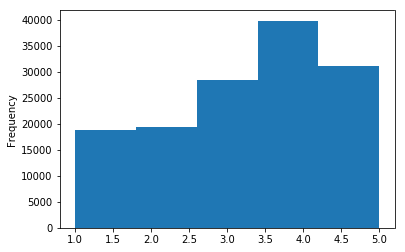

In [73]:
nutrition_grades['nutrition_grade_numeric'].plot.hist(bins=5)